## Libaries

As always, we load lots of libraries.

In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [17]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
# data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 115172960.77it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 121135693.82it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31488111.62it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19990061.67it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [18]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [19]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [4]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [20]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

In [5]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [21]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [6]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


D = Discriminator().to(DEVICE) # randomly initialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100  # size of the noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

all_ones = torch.ones([batch_size, 1]).to(DEVICE)  # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE)  # Discriminator label: fake

In [22]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        class_labels = class_labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        class_labels = to_onehot(class_labels).to(DEVICE)
        x_outputs = D(x, class_labels) # input includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels)
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3514288663864136, G Loss: -0.6830189824104309
Epoch: 0/10, Step: 500, D Loss: 1.1450117826461792, G Loss: -0.5035810470581055
Epoch: 1/10, Step: 1000, D Loss: 1.1381268501281738, G Loss: -0.4759160578250885
Epoch: 1/10, Step: 1500, D Loss: 1.2079648971557617, G Loss: -0.6697063446044922
Epoch: 2/10, Step: 2000, D Loss: 1.2449171543121338, G Loss: -0.43948161602020264
Epoch: 2/10, Step: 2500, D Loss: 1.2173736095428467, G Loss: -0.5826414823532104
Epoch: 3/10, Step: 3000, D Loss: 1.3378918170928955, G Loss: -0.5487537384033203
Epoch: 3/10, Step: 3500, D Loss: 1.3011475801467896, G Loss: -0.6142688393592834
Epoch: 4/10, Step: 4000, D Loss: 1.2872161865234375, G Loss: -0.6764382123947144
Epoch: 4/10, Step: 4500, D Loss: 1.3877155780792236, G Loss: -0.739016592502594
Epoch: 5/10, Step: 5000, D Loss: 1.3732285499572754, G Loss: -0.9222396016120911
Epoch: 5/10, Step: 5500, D Loss: 1.2177181243896484, G Loss: -0.5097173452377319
Epoch: 6/10, Step: 6000, D Loss:

In [7]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):  # No class labels
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)  # No class labels
        D_x_loss = criterion(x_outputs, all_ones)  # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))  # No class labels
        D_z_loss = criterion(z_outputs, all_zeros)  # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss  # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = criterion(z_outputs, all_ones)  # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.362381935119629, G Loss: 0.7160969972610474
Epoch: 0/10, Step: 500, D Loss: 1.2294949293136597, G Loss: 1.4084221124649048
Epoch: 1/10, Step: 1000, D Loss: 1.3241937160491943, G Loss: 1.1526758670806885
Epoch: 1/10, Step: 1500, D Loss: 1.4414507150650024, G Loss: 0.6690715551376343
Epoch: 2/10, Step: 2000, D Loss: 1.354343295097351, G Loss: 0.7686076164245605
Epoch: 2/10, Step: 2500, D Loss: 1.2374329566955566, G Loss: 0.9881440997123718
Epoch: 3/10, Step: 3000, D Loss: 1.3842191696166992, G Loss: 1.3369228839874268
Epoch: 3/10, Step: 3500, D Loss: 1.2120521068572998, G Loss: 0.9725512862205505
Epoch: 4/10, Step: 4000, D Loss: 1.338620662689209, G Loss: 1.0967302322387695
Epoch: 4/10, Step: 4500, D Loss: 1.3118302822113037, G Loss: 0.9211345314979553
Epoch: 5/10, Step: 5000, D Loss: 1.3415734767913818, G Loss: 0.9145141243934631
Epoch: 5/10, Step: 5500, D Loss: 1.3334400653839111, G Loss: 0.7846530079841614
Epoch: 6/10, Step: 6000, D Loss: 1.225565910339

Now let's plot these images. At first, the generator just produces noise (as we expect).

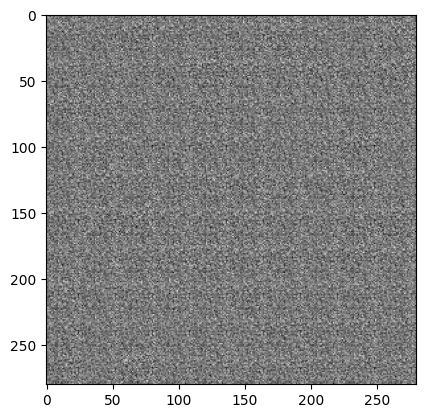

In [23]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

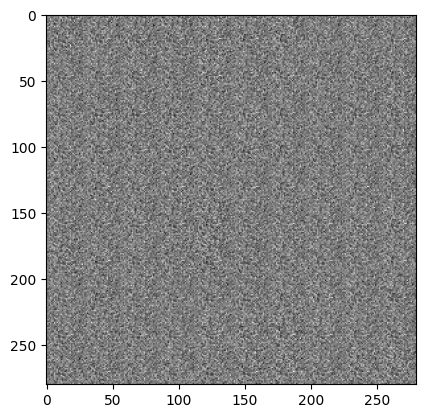

In [8]:
img = mpimg.imread('/content/samples/GAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

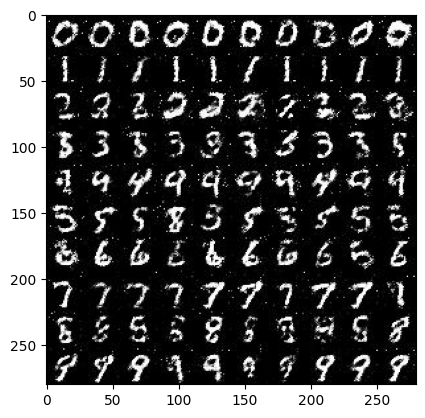

In [24]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

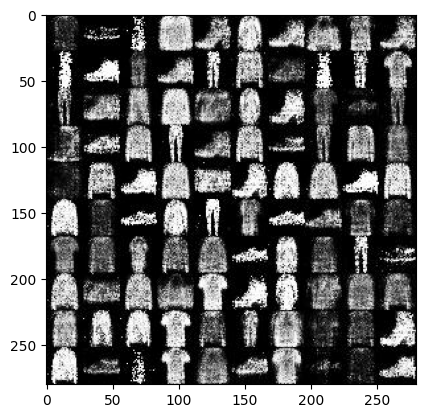

In [9]:
img = mpimg.imread('/content/samples/GAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

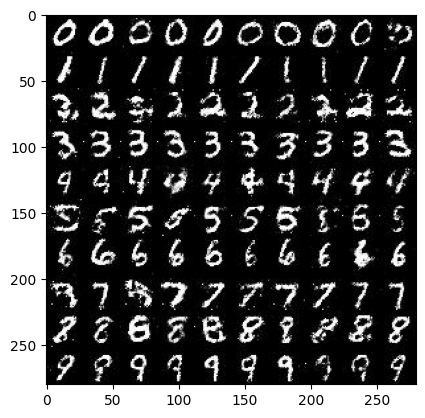

In [25]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

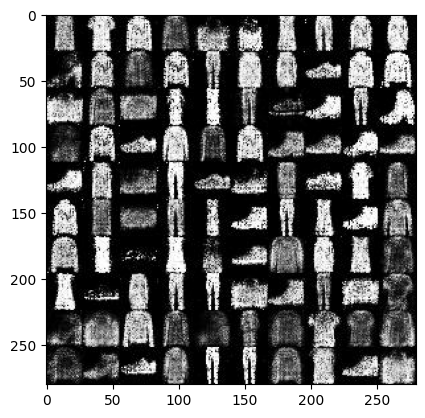

In [10]:
img = mpimg.imread('/content/samples/GAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

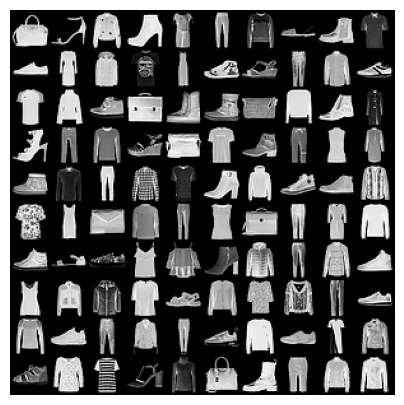

In [16]:
import torchvision.utils as vutils

def plot_grid_of_images(images, nrow=10, normalize=True):
    grid = vutils.make_grid(images, nrow=nrow, normalize=normalize, padding=2, scale_each=True)

    np_grid = grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(5, 5))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.show()

num_images = 100
images = []
for img, _ in data_loader:
    images.append(img)
    if len(images) * img.size(0) >= num_images:
        break
images = torch.cat(images, dim=0)[:num_images]
plot_grid_of_images(images)

It is clear that GAN preform well in generating FashionMNIST image. Compare to Conditional GAN, the images generated by GAN have more clear edge and better shape. Some of the number generated by CGAN could not be recognized well.
